# Introduction

In this project, we'll be working with a dataset containing information on the number of bicycles people rent by hour and day. The aim of the project is to predict the total number of bikes people rented in a given hour.  We'll be predicting the 'cnt' column (containing the total number of bike rentals) using all other columns in the dataset. We'll be creating a few different machine learning models and evaluating their performance.

# Reading in the Data & Exploring Correlations

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


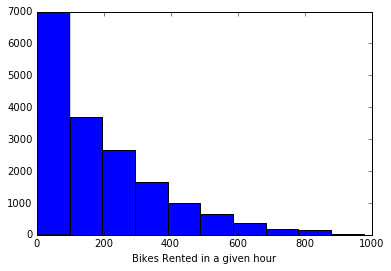

In [8]:
%matplotlib inline
plt.hist(bike_rentals['cnt'])
plt.xlabel('Bikes Rented in a given hour')

It seems as if in a given hour, 100 or less bikes are rented the most often.  There are a small number of hours where 800 or more bikes were rented.

In [12]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Seems as if the temperature and air temperature on a given hour correlates slightly positively with the number of bikes rented.  
We're now going to perform some feature engineering to group hours in a day into specific periods - morning, afternoon, eveniing and night which we will number from 1 to 4.

In [13]:
def assign_label(hour):
    if hour >=0 and hour <6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >=12 and hour < 18:
        return 2
    else:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [16]:
bike_rentals['time_label'].head(10)

0    4
1    4
2    4
3    4
4    4
5    4
6    1
7    1
8    1
9    1
Name: time_label, dtype: int64

# Splitting the dataset up & Selecting an error metric

We'll split the dataset up into a training and test set now to prepare the data for training. 

To analyse the performance of the models we'll use the mean squared error metric, as it works well with continuous numeric data.

In [17]:
train = bike_rentals.sample(frac=0.8)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [18]:
features = list(train.columns)
features.remove('cnt')
features.remove('casual')
features.remove('dteday')
features.remove('registered')

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(train[features], train['cnt'])

predictions = linear_model.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)

print(mse)

17952.199962985265


This error seems very large.  A potential explanation for this is that most values in the 'cnt' columns are small but there are some very large values in there, as shown in the histogram above.  This means that the error in the model for the large values is magnified, resulting in such a large error.

# Using the Decision Tree Regressor Model

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [25]:
decision_model = DecisionTreeRegressor()

decision_model.fit(train[features], train['cnt'])

predictions = decision_model.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)

print(mse)

2866.67836593786


This model has a much smaller mean squared error than the Linear Regression model, which is great.  However, we must be aware of the potential of the model to overfit data - so we'll try and tweak some parameters.

In [26]:
decision_model = DecisionTreeRegressor(min_samples_leaf = 3)

decision_model.fit(train[features], train['cnt'])

predictions = decision_model.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)

print(mse)

2488.72872906278


Reducing min_samples_leaf actually ended up reducing the error.

# Using the Random Forest Regressor Model

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
random_model = RandomForestRegressor()

random_model.fit(train[features], train['cnt'])

predictions = random_model.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)

print(mse)

1658.840080552359


In [30]:
random_model = RandomForestRegressor(n_estimators = 200, min_samples_leaf=3)

random_model.fit(train[features], train['cnt'])

predictions = random_model.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)

print(mse)

1441.5266171711382


The Random Forest model has a smaller error than the Decision Tree model, likely due to potential sources of overfitting being removed - as Random Forests are much less prone to overfitting than single decision trees. Increasing the number of trees makes the algorithm take longer to predict the values, but it resulted in a smaller MSE, alongside reducing the number of samples per leaf.